# Семинар 9. Метрики качества классификации. Многоклассовая классификаци

 - коллоквиум 12 апреля
 - [вопросы](https://docs.google.com/document/d/17rXxZvS1gjZUwvns-bFrh1lsR2I5HygeNKJm5ZJQd_E/edit#heading=h.fufpprwa66pk) к коллоквиуму
 
## Метрики качества классификации

Очень часто классификатор выдает не сам класс, а некоторую оценку принадлежности к классу (например, логистическая регрессия выдает вероятность). Тогда итоговый классификатор имеет вид: $$a(x) = [b(x) > t]$$ где $b(x)$ — ответ классификатора (оценка принадлежности классу +1), $t$ — некоторый фиксированный порог.

Это позволяет варьировать значение $t$, тем самым меняя качество: 
 - чем больше $t$, тем выше точность, но ниже полнота
 - чем меньше $t$, тем выше полнота, но ниже точность
 
Рассмотрим задачу кредитного скоринга в немного другой интерпретации: по некоторой банковской информации необходимо понять, будет ли испытывать клиент финансовые затруднения в будущем. Данные взяты из [этого](https://www.kaggle.com/c/GiveMeSomeCredit) соревнования. Целевая переменная *SeriousDlqin2yrs* — 1 если финансовые затруднения будут, 0 в противном случае.

In [1]:
import pandas as pd
import numpy as np
import pylab as plt

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
data.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 0                              0.000000   39   
1                 0                              0.047902   69   
2                 0                              0.005831   88   
3                 0                              0.000000   62   
4                 0                              0.000000   48   

   NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
0                                     0     0.371156           6600   
1                                     1  2988.000000              0   
2                                     0     0.001946           9763   
3                                     0     0.459369           3900   
4                                     0     0.225303           7500   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                6                        0   
1                                9                        0   
2                                8                        0   
3                                7                        0   
4                               14                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             1                                     0   
1                             2                                     0   
2                             0                                     0   
3                             1                                     0   
4                             2                                     0   

   NumberOfDependents  
0                   3  
1                   0  
2                   0  
3                   1  
4                   1

Можно заметить что выборка весьма несбалансирована:

In [3]:
data['SeriousDlqin2yrs'].value_counts()

0    27939
1     2061
Name: SeriousDlqin2yrs, dtype: int64

Попробуем посмотреть какое качество дает один из пройденных алгоритмов:

In [4]:
from sklearn.linear_model import LogisticRegression

In [8]:
from sklearn.cross_validation import KFold, cross_val_score, train_test_split

In [9]:
X, y = data.drop(['SeriousDlqin2yrs'], axis=1), data['SeriousDlqin2yrs']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Оценим *precision* и *recall*:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

$precision = \dfrac{TP}{TP + FP}$

$recall = \dfrac{TP}{TP + FN}$

In [32]:
from sklearn.metrics import precision_score, recall_score

In [35]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
print 'precision:', precision_score(y_test, clf.predict(X_test))
print 'recall:', recall_score(y_test, clf.predict(X_test))

precision: 0.533333333333
recall: 0.0376766091052


Известно, что логистическая регрессия умеет возвращать вероятность принадлежности классу. Можно ли в данном случае ослабить порог, чтобы, например, полнота была выше при той же точности?

In [36]:
from sklearn.metrics import precision_recall_curve

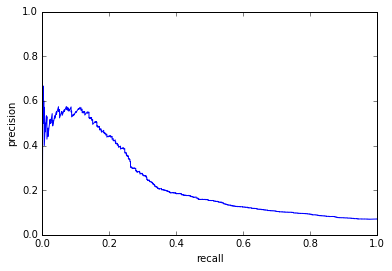

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

In [54]:
recall[precision >= 0.3][0]

0.26844583987441129

И еще одна характеристика, которая является следствием графика выше: площадь под кривой.

In [39]:
from sklearn.metrics import auc

In [40]:
auc(recall, precision)

0.22875668832460233

В данном случае она не такая уж большая.

В данной выборке признаки имеют разные масшатбы. Посмотрим повлияет ли масштабирование на качество модели:

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()
scaler.fit(X_train)

new_X_train = scaler.transform(X_train)
new_X_test = scaler.transform(X_test)

In [43]:
clf_scaled = LogisticRegression(random_state=42)
clf_scaled.fit(new_X_train, y_train)
print 'precision:', precision_score(y_test, clf_scaled.predict(new_X_test))
print 'recall:', recall_score(y_test, clf_scaled.predict(new_X_test))

precision: 0.548387096774
recall: 0.0266875981162


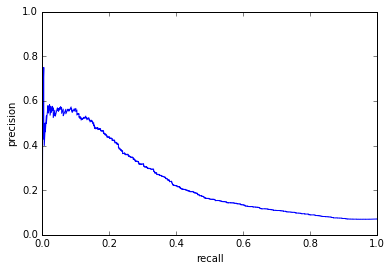

In [44]:
precision_scaled, recall_scaled, thresholds = precision_recall_curve(y_test, clf_scaled.predict_proba(new_X_test)[:, 1])
plt.plot(recall_scaled, precision_scaled)
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

Аналогично:

In [55]:
recall_scaled[precision_scaled >= 0.3][0]

0.31397174254317112

In [56]:
auc(recall_scaled, precision_scaled)

0.2389065332622245

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - $FPR = \frac{FP}{FP + TN}$
 - $TPR = \frac{TP}{TP + FN}$
 
$AUC-ROC$ — площадь под такой кривой. Наихудший классификатор имеет площадь $0.5$, идеальный — 1.

In [57]:
from sklearn.metrics import roc_curve

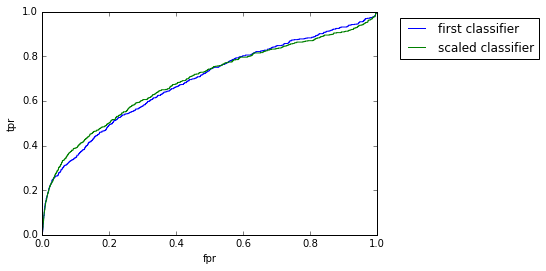

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
fpr_scaled, tpr_scaled, thresholds = roc_curve(y_test, clf_scaled.predict_proba(new_X_test)[:, 1])
plt.plot(fpr, tpr, label='first classifier')
plt.plot(fpr_scaled, tpr_scaled, label='scaled classifier')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [59]:
auc(fpr, tpr)

0.68626562279728431

In [60]:
auc(fpr_scaled, tpr_scaled)

0.69065645923745378

## Многоклассовая классификация

Одна из стратегий многоклассовой классификации *One-vs-All*:
 - для каждого класса строим свой классификатор
 - *K* различных классификаоров
 - рашающее правило: пытаемся отнести классификатор к каждому из классов, выбираем тот, значение на котором у классификатора больше всего
 
![](http://i.imgur.com/3GVuwGD.png)


Плюс sklearn — все уже работает "из коробки". По умолчанию для многоклассового случая реализована стратегия One-vs-Rest.

In [61]:
from sklearn.datasets import make_classification

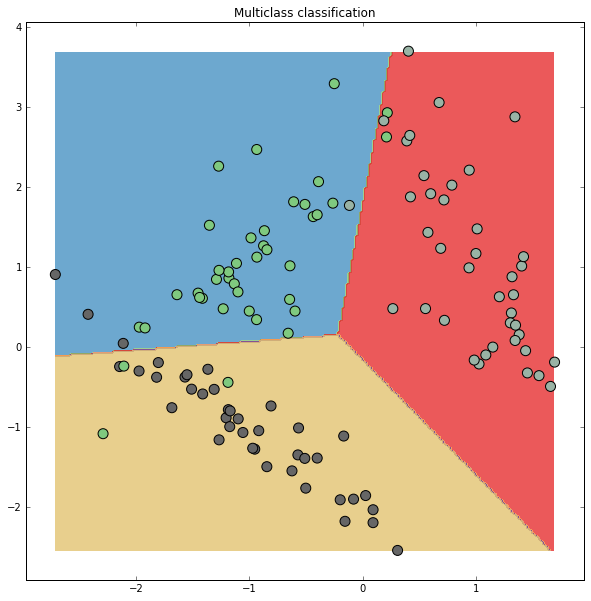

In [66]:
X, y = make_classification(n_classes=3, n_features=2, n_clusters_per_class=1, 
                           n_informative=2, n_redundant=0, n_samples=120, random_state=42)
min_x = np.min(X[:, 0])
max_x = np.max(X[:, 0])

min_y = np.min(X[:, 1])
max_y = np.max(X[:, 1])

classif = LogisticRegression(random_state=42)
classif.fit(X, y)

plt.figure(figsize=(10, 10))
plt.title("Multiclass classification")
h = 0.02
xx, yy = np.meshgrid(np.arange(min_x, max_x, h),
                     np.arange(min_y, max_y, h))

Z = classif.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Accent, s=100)

plt.show()

## Полиномиальная регрессия

Ранее рассматривался один тип модели регрессии — линейная. Это означает, что ищется алгорим вида $$ a(x) = w_0 + \sum_{j=1}^k w_jx^j = \sum_{j=0}^k w_jx^j$$

Но что делать если на самом деле данные имеют более сложный вид?

Рассмотрим простой пример: пусть истинная зависимость имеет вид $y = x * \sin(x)$

Сгенерируем такую выборку и по части точек будем обучаться (*train*), а на оставшихся — оценивать качество (*test*).

In [67]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Эту зависимость можно изобразить на графике (синим показаны точки для обучающей выборки, зеленым — тестовой).

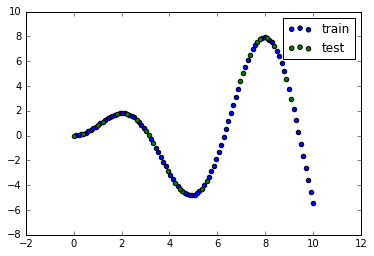

In [68]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
_ = plt.legend(('train', 'test'))

Теперь применим известную нам модель линейной регрессии:

In [69]:
from sklearn.linear_model import LinearRegression

In [70]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Посчитаем качество нашей модели:

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [72]:
prediction = lr.predict(X_test[:, np.newaxis])
print "MSE:", mean_squared_error(y_test, prediction) 
print "MAE:", mean_absolute_error(y_test, prediction) 
print "r2:", r2_score(y_test, prediction) 

MSE: 14.7599775028
MAE: 3.19823417124
r2: 0.0685661961929


Судя по метрикам, наша модель работает не самым лучшим образом. Изобразим ее на графике:

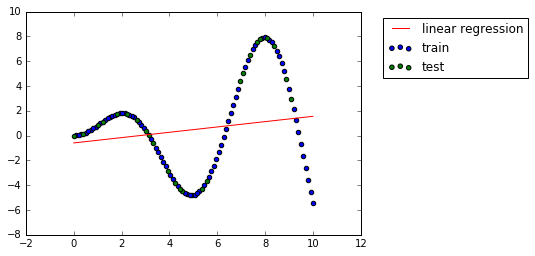

In [73]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Кажется линейная зависимость совсем не подходит под наши данные. Чтобы как-то исправить это одиним из подходов является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots , x_d, x^2_1, x_1x_2, \dots , x^2_d, \dots$

In [74]:
from sklearn.preprocessing import PolynomialFeatures

In [75]:
poly = PolynomialFeatures(degree=2)
poly.fit(X_train[:, np.newaxis])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

In [76]:
new_features = poly.transform(X_train[:, np.newaxis])
new_features.shape

(75, 3)

In [77]:
new_test_features = poly.transform(X_test[:, np.newaxis])

In [78]:
lr2 = LinearRegression()
lr2.fit(new_features, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [79]:
prediction = lr2.predict(new_test_features)
print "MSE:", mean_squared_error(y_test, prediction) 
print "MAE:", mean_absolute_error(y_test, prediction) 
print "r2:", r2_score(y_test, prediction) 

MSE: 13.6939938774
MAE: 3.01139113345
r2: 0.135835484569


Судя по всему, уже лучше!

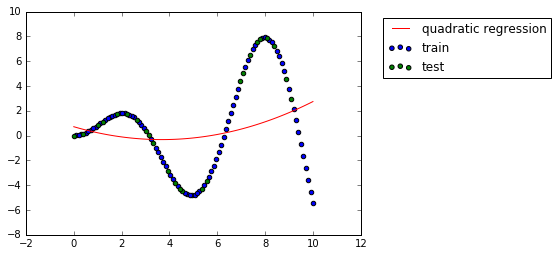

In [80]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr2.predict(poly.transform(X[:, np.newaxis]))
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('quadratic regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Теперь можно попробовать различные степени!

degree: 2
 MSE: 13.6939938774
 MAE: 3.01139113345
 r2: 0.135835484569
degree: 3
 MSE: 11.0905318302
 MAE: 3.04851665191
 r2: 0.300127913683
degree: 4
 MSE: 1.94641536663
 MAE: 1.19021797393
 r2: 0.877170743087


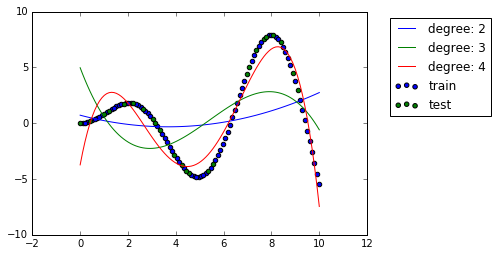

In [81]:
_ = plt.scatter(X_train, y_train, label='train')
_ = plt.scatter(X_test, y_test, c='g', label='test')

for degree in range(2, 5):
    print "degree:", degree
    poly = PolynomialFeatures(degree=degree)
    poly.fit(X_train[:, np.newaxis])
    new_features = poly.transform(X_train[:, np.newaxis])
    new_test_features = poly.transform(X_test[:, np.newaxis])
    
    lr = LinearRegression()
    lr.fit(new_features, y_train)
    
    prediction = lr.predict(new_test_features)
    print " MSE:", mean_squared_error(y_test, prediction) 
    print " MAE:", mean_absolute_error(y_test, prediction) 
    print " r2:", r2_score(y_test, prediction) 
    

    y_plot = lr.predict(poly.transform(X[:, np.newaxis]))
    _ = plt.plot(X, y_plot, label='degree: %s' % degree)

_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Но что будет если увеличивать степень полинома?

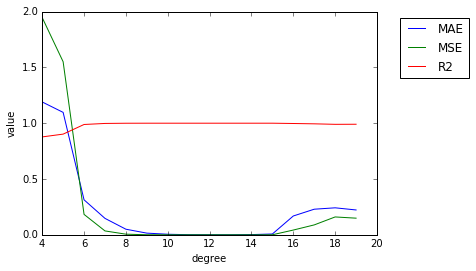

In [82]:
mae = []
mse = []
r2 = []
degrees = range(4, 20)
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    poly.fit(X_train[:, np.newaxis])
    new_features = poly.transform(X_train[:, np.newaxis])
    new_test_features = poly.transform(X_test[:, np.newaxis])
    
    lr = LinearRegression()
    lr.fit(new_features, y_train)
    
    prediction = lr.predict(new_test_features)
    mse.append(mean_squared_error(y_test, prediction))
    mae.append(mean_absolute_error(y_test, prediction))
    r2.append(r2_score(y_test, prediction))

plt.plot(degrees, mae, label='MAE')
plt.plot(degrees, mse, label='MSE')
plt.plot(degrees, r2, label='R2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('degree')
plt.ylabel('value')
plt.show()

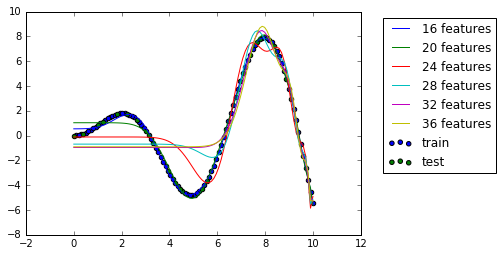

In [83]:
_ = plt.scatter(X_train, y_train, label='train')
_ = plt.scatter(X_test, y_test, c='g', label='test')

for degree in range(16, 40, 4):
    poly = PolynomialFeatures(degree=degree)
    poly.fit(X_train[:, np.newaxis])
    new_features = poly.transform(X_train[:, np.newaxis])
    new_test_features = poly.transform(X_test[:, np.newaxis])
    
    lr = LinearRegression()
    lr.fit(new_features, y_train)
    
    prediction = lr.predict(new_test_features)

    y_plot = lr.predict(poly.transform(X[:, np.newaxis]))
    _ = plt.plot(X, y_plot, label='%s features' % degree)

_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Какие недостатки такого подхода? При увеличении степени полинома получаем:
 - переобучение
 - очень много признаков